In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/linkedin-job-data/linkdin_Job_data.xlsx
/kaggle/input/linkedin-job-data/linkdin_Job_data.csv


In [2]:
#Visualization set up
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")



Setup Complete


In [3]:
# -----------------------------
# 1. Import libraries and set up SQLite
# -----------------------------
import pandas as pd
from sqlalchemy import create_engine, text

# -----------------------------
# 2. Load CSV
# -----------------------------
linkedin_filepath = "/kaggle/input/linkedin-job-data/linkdin_Job_data.csv"
linkedin_data = pd.read_csv(linkedin_filepath)

# -----------------------------
# 3. Create SQLite in-memory engine and load DataFrame into SQL
# -----------------------------
engine = create_engine("sqlite://", echo=False)
linkedin_data.to_sql("my_table", con=engine, index=False, if_exists="replace")

# -----------------------------
# 4. Identify columns that are not completely NULL
# -----------------------------
columns = linkedin_data.columns.tolist()
columns_to_keep = []

with engine.connect() as conn:
    for col in columns:
        result = conn.execute(
            text(f'SELECT COUNT([{col}]) AS non_null_count FROM my_table')
        ).fetchone()
        if result[0] > 0:
            columns_to_keep.append(col)

print("Columns to keep:", columns_to_keep)

# -----------------------------
# 5. Create a cleaned table with only non-null columns
# -----------------------------
cols_str = ", ".join([f'[{c}]' for c in columns_to_keep])
with engine.connect() as conn:
    conn.execute(text(f'CREATE TABLE my_table_clean AS SELECT {cols_str} FROM my_table'))

# -----------------------------
# 6. Load cleaned table into pandas
# -----------------------------
with engine.connect() as conn:
    cleaned_df = pd.read_sql("SELECT * FROM my_table_clean", conn)

# -----------------------------
# 7. Remove duplicates based on Job Title + Company Name
# -----------------------------
dedup_df = cleaned_df.drop_duplicates(subset=["job", "company_name"]).reset_index(drop=True)

# Store the deduplicated table back into SQLite
dedup_df.to_sql("my_table_dedup", con=engine, index=False, if_exists="replace")

# -----------------------------
# 8. Preview final deduplicated table
# -----------------------------
with engine.connect() as conn:
    final_df = pd.read_sql("SELECT * FROM my_table_dedup", conn)

# -----------------------------
# 9. Split full_time_remote into two separate columns
# -----------------------------
if "full_time_remote" in final_df.columns:
    final_df[["employment_type", "seniority_level"]] = (
        final_df["full_time_remote"]
        .str.split("·", n=1, expand=True)   # split into 2 parts max
        .apply(lambda col: col.str.strip()) # remove surrounding spaces
    )
    # Drop the original column
    final_df = final_df.drop(columns=["full_time_remote"])

# -----------------------------
# 10. Store updated dataset back into SQLite
# -----------------------------
final_df.to_sql("my_table_updated", con=engine, index=False, if_exists="replace")

# -----------------------------
# 11. Preview updated dataset
# -----------------------------
with engine.connect() as conn:
    updated_df = pd.read_sql("SELECT * FROM my_table_updated", conn)

updated_df.head()


Columns to keep: ['job_ID', 'job', 'location', 'company_name', 'work_type', 'full_time_remote', 'no_of_employ', 'no_of_application', 'posted_day_ago', 'alumni', 'Hiring_person', 'linkedin_followers', 'hiring_person_link', 'job_details']


,job_ID,job,location,company_name,work_type,no_of_employ,no_of_application,posted_day_ago,alumni,Hiring_person,linkedin_followers,hiring_person_link,job_details,employment_type,seniority_level
0,3471657636,"Data Analyst, Trilogy (Remote) - $60,000/year USD","Delhi, Delhi, India",Crossover,Remote,"1,001-5,000 employees · IT Services and IT Con...",200,8 hours,12 company alumni,None,"5,395,547 followers",None,About the job Crossover is the world's #1 sour...,Full-time,Associate
1,3474349934,Data Analyst - WFH,Greater Bengaluru Area,Uplers,Remote,"1,001-5,000 employees · IT Services and IT Con...",200,9 hours,3 company alumni,Shahid Ahmad,None,https://www.linkedin.com/in/shahid-ahmad-a2613...,About the job Profile: ML EngineersExperience:...,Full-time,Mid-Senior level
2,3472816027,Data Analyst,"Gurugram, Haryana, India",PVAR SERVICES,On-site,1-10 employees,200,7 hours,None,Vartika Singh,"2,094 followers",https://www.linkedin.com/in/vartika-singh-,About the job Designation: Data AnalystLocatio...,Full-time,None
3,3473311511,Data Analyst,"Mohali district, Punjab, India",Timeline Freight Brokers,On-site,1-10 employees,8,26 minutes,1 company alumni,Manisha (Gisele Smith),None,https://www.linkedin.com/in/manisharathore0029,About the job The ideal candidate will use the...,Full-time,None
4,3472504479,Data Analyst,"Gurugram, Haryana, India",airtel,On-site,"10,001+ employees · Telecommunications",200,10 hours,132 company alumni,None,"972,657 followers",None,About the job The ideal candidate will use the...,Full-time,Entry level


<Axes: xlabel='work_type', ylabel='count'>

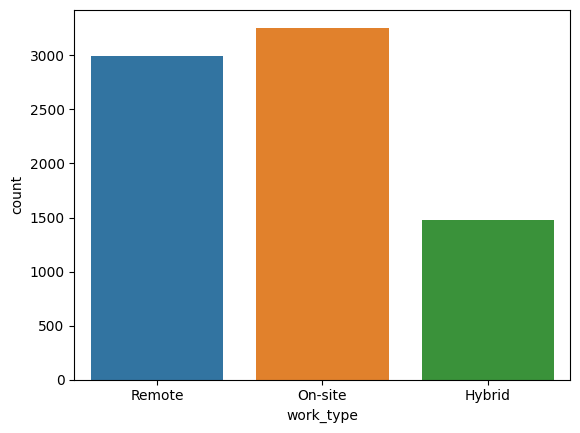

In [4]:
sns.countplot(data=linkedin_data, x='work_type', )

<Axes: xlabel='work_type', ylabel='count'>

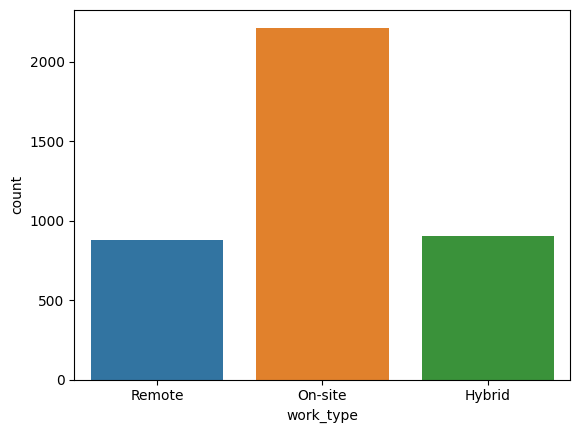

In [5]:

sns.countplot(data=final_df, x='work_type'  )

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


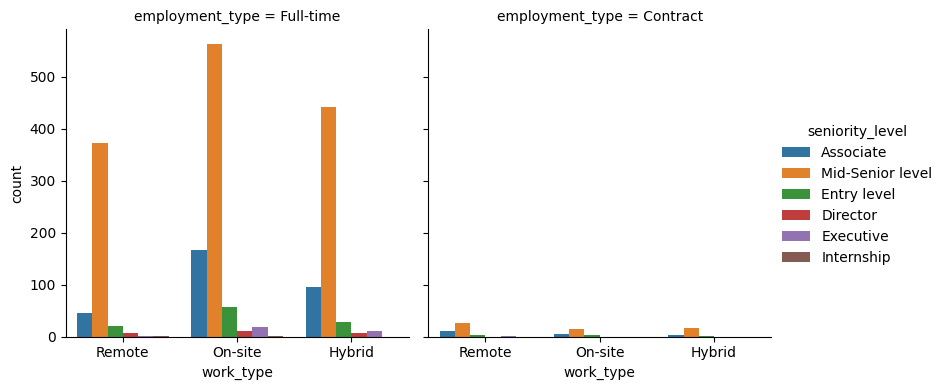

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for only Full-time and Contract positions
subset_df = final_df[final_df["employment_type"].isin(["Full-time", "Contract"])]

# Facet by employment_type
g = sns.catplot(
    data=subset_df,
    x="work_type",
    hue="seniority_level",
    col="employment_type",   # now only Full-time and Contract will appear
    kind="count",
    height=4,
    aspect=1
)

plt.show()
